In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

In [2]:
ETF_data_file = 'history/NDX.csv'
date_column = 'Date'
price_column = 'Close'
output_excel_file = 'ndx_cost_averaging.xlsx'

hold_duration_years = 5
hold_duration_days = 252*hold_duration_years

start_date = '0000-01-01'
end_date = '9999-01-01'

In [3]:
month_mapping = {
    "Jun":6,
    "May":5,
    "Apr":4,
    "Mar":3,
    "Feb":2,
    "Jan":1,
    "Dec":12,
    "Nov":11,
    "Oct":10,
    "Sep":9,
    "Aug":8,
    "Jul":7,
    }

def date_normalize(date):
    try:
        result = re.search(r'(?P<m>\d+)\/(?P<d>\d+)\/(?P<y>\d+)', date).groupdict()
        output = '%04d-%02d-%02d'%(
            int(result['y']),
            int(result['m']),
            int(result['d']),
            )
        return output
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2}) (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2}), (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    return date


date = '9/17/2015'
date = 'Jun 14 2022'
date = 'Apr 01, 1929'

date_normalize(
    date,
    )

'1929-04-01'

In [4]:
def str_to_float(input):
    try:
        return float(re.sub(r'[^\d\.]', r'', input))
    except:
        return input

In [5]:
if '.csv' in ETF_data_file.lower():
    data = pd.read_csv(
        ETF_data_file,
        )
else:
    data = pd.read_excel(
        ETF_data_file,
        )

data[date_column] = data[date_column].apply(date_normalize)
data[price_column] = data[price_column].apply(str_to_float)

data = pysqldf(u"""
    select 
    {} as date,
    {} as price
    from data
    """.format(
    date_column, 
    price_column
   ))

data = pysqldf(u"""
    select *
    from data
    where date >= '{}' and date <= '{}'
    order by date asc
    """.format(
    start_date, 
    end_date))


data['id'] = data.index

In [6]:
data.tail(3)

,date,price,id
9273,2022-07-18,11877.50000,9273
9274,2022-07-19,12249.41992,9274
9275,2022-07-20,12439.67969,9275


# the return

In [7]:
holding = pysqldf(u"""
    select 
    data.date,
    data.price,
    pre_data.date as pre_date,
    pre_data.price as pre_price
    from data
    join data as pre_data on pre_data.id+{} = data.id
    """.format(hold_duration_days))

In [8]:
holding.tail(3)

,date,price,pre_date,pre_price
8013,2022-07-18,11877.50000,2017-07-14,5838.080078
8014,2022-07-19,12249.41992,2017-07-17,5839.740234
8015,2022-07-20,12439.67969,2017-07-18,5880.100098


In [9]:
window_data = pysqldf(u"""
    select boundary.*,
    window.date as window_date,
    1000.0/window.price as window_shares,
    window.price as window_price
    from holding as boundary
    join data as window
    on window.date >= boundary.pre_date and window.date < boundary.date
    """)

In [10]:
window_aggrated = pysqldf(u"""
    select date, 
    count(*)*1000.0 as invested_amount,
    sum(window_shares) as bought_shares,
    price
    from window_data 
    group by date
    """)

In [11]:
window_ratio =  pysqldf(u"""
    select *,
    bought_shares*price/invested_amount as ratio
    from window_aggrated 
    order by date asc
    """)

In [12]:
window_ratio =  pysqldf(u"""
    select *, 
    bought_shares*price as sold_amount
    from window_ratio
    """)

In [13]:
window_ratio.to_excel(output_excel_file, index = False)

In [14]:
window_ratio.tail(3)

,date,invested_amount,bought_shares,price,ratio,sold_amount
8013,2022-07-18,1260000.0,141.227607,11877.50000,1.331294,1.677431e+06
8014,2022-07-19,1260000.0,141.140511,12249.41992,1.372134,1.728889e+06
8015,2022-07-20,1260000.0,141.050907,12439.67969,1.392562,1.754628e+06


<AxesSubplot:xlabel='date'>

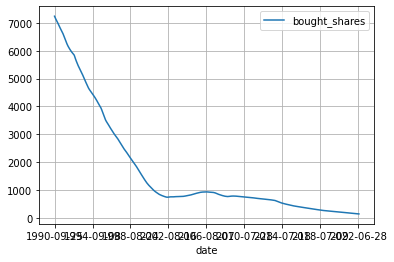

In [15]:
window_ratio.plot(x ='date', y=[
    'bought_shares', 
    ], grid = True)

<AxesSubplot:xlabel='date'>

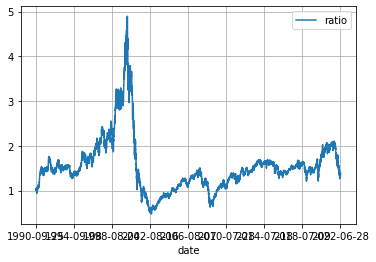

In [16]:
window_ratio.plot(x ='date', y=[
    'ratio', 
    ], grid = True)

In [17]:
window_ratio.tail(3)

,date,invested_amount,bought_shares,price,ratio,sold_amount
8013,2022-07-18,1260000.0,141.227607,11877.50000,1.331294,1.677431e+06
8014,2022-07-19,1260000.0,141.140511,12249.41992,1.372134,1.728889e+06
8015,2022-07-20,1260000.0,141.050907,12439.67969,1.392562,1.754628e+06


<AxesSubplot:>

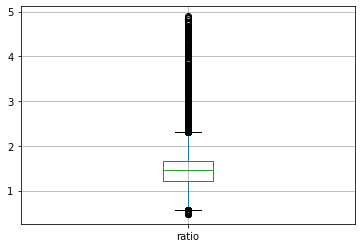

In [18]:
window_ratio.boxplot(column=['ratio']) 

In [19]:
sold_amount = window_ratio['sold_amount'].median()

print('sold_amount:\t%0.4f'%(sold_amount))

sold_amount:	1834083.9489


In [20]:
ratio = window_ratio['ratio'].median()

print('Ratio:\t%0.4f'%(ratio))

Ratio:	1.4556


##### END